# Assignment 4

Deadline: 30.04.2025 12:00 CET

<Add your name, student-id and emal address>

## Prerequisites: Library imports, data load and initialization of the backtest service

In [2]:
# Standard library imports
import os
import sys
import copy
from typing import Optional

# Third party imports
import numpy as np
import pandas as pd

# Add the project root directory to Python path
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   # Change this path if needed
src_path = os.path.join(project_root, 'qpmwp-course', 'src')
sys.path.append(project_root)
sys.path.append(src_path)

# Local modules imports
from helper_functions import load_data_spi, load_pickle
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.optimization import Optimization, Objective, MeanVariance
from optimization.optimization_data import OptimizationData
from optimization.constraints import Constraints
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_min_volume,
    bibfn_selection_gaps,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
    bibfn_size_dependent_upper_bounds,
)
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

In [3]:
# Load data
path_to_data = '/Users/sarah/qpmwp-course/data/'  # <change this to your path to data>

# Load market and jkp data from parquet files
market_data = pd.read_parquet(path = f'{path_to_data}market_data.parquet')

# Instantiate the BacktestData class
# and set the market data and jkp data as attributes
data = BacktestData()
data.market_data = market_data
data.bm_series = load_data_spi(path='../data/')  # <change this if necessary>

In [4]:
# Define rebalancing dates
n_days = 21*3
market_data_dates = market_data.index.get_level_values('date').unique().sort_values(ascending=True)
rebdates = market_data_dates[market_data_dates > '2015-01-01'][::n_days].strftime('%Y-%m-%d').tolist()

In [5]:
# Define the selection item builders.
selection_item_builders = {
    'gaps': SelectionItemBuilder(
        bibfn = bibfn_selection_gaps,
        width = 252*3,
        n_days = 10,
    ),
    'min_volume': SelectionItemBuilder(
        bibfn = bibfn_selection_min_volume,
        width = 252,
        min_volume = 500_000,
        agg_fn = np.median,
    ),
}

# Define the optimization item builders.
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series,
        width = 252*3,
        fill_value = 0,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1,
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.1,
    ),
    'size_dep_upper_bounds': OptimizationItemBuilder(
        bibfn = bibfn_size_dependent_upper_bounds,
        small_cap = {'threshold': 300_000_000, 'upper': 0.02},
        mid_cap = {'threshold': 1_000_000_000, 'upper': 0.05},
        large_cap = {'threshold': 10_000_000_000, 'upper': 0.1},
    ),
}

# Initialize the backtest service
bs = BacktestService(
    data = data,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
)

## 1. Maximum Sharpe Ratio Portfolio

a) 

(6 points)

Complete the `MaxSharpe` class below by implementing your its methods `set_objective` and `solve`.
The `solve` method should implement an iterative algorithm that quickly approximates the "true" maximimum Sharpe ratio portfolio (given the estimates of mean and covariance). This approximation should be done by repeatedly solving a mean-variance optimization problem, where the risk aversion parameter (which scales the covariance matrix) is adjusted in each iteration. The algorithm should terminate after a maximum of 10 iterations. 

In [6]:
# Thought process: 1. solve mean-variance for 10 different values of risk aversion parameter (use this parameter as a control param for balancing risk and return) 
#                  2. find the weights that give the highest sharpe ratio
class MaxSharpe(Optimization):

    def __init__(self,
                 constraints: Optional[Constraints] = None,
                 covariance: Optional[Covariance] = None,
                 expected_return: Optional[ExpectedReturn] = None,
                 **kwargs) -> None:
        super().__init__(
            constraints=constraints,
            **kwargs,
        )
        self.covariance = Covariance() if covariance is None else covariance
        self.expected_return = ExpectedReturn() if expected_return is None else expected_return

    def set_objective(self, optimization_data: OptimizationData) -> None:
        self.optimization_data = optimization_data

        X = optimization_data['return_series']
        mu = self.expected_return.estimate(X=X, inplace=False)
        covmat = self.covariance.estimate(X=X, inplace=False)
        ids = self.constraints.ids

        self.mu = pd.Series(mu, index=X.columns).reindex(ids).to_numpy()
        self.Sigma = pd.DataFrame(covmat, index=X.columns, columns=X.columns).reindex(index=ids, columns=ids).to_numpy()

        self.objective = Objective(
            q = -self.mu,
            P = 2 * self.Sigma,
        )
        return None

    def solve(self) -> None:
        max_iter = 10
        tol = 1e-6
        ids = self.constraints.ids
        n = len(ids)
        gamma = 1.0
        prev_weights = self.results.get('prev_weights', {})
        w_prev = np.array([prev_weights.get(i, 0.0) for i in ids])
        turnover_penalty = self.params.get('turnover_penalty', 0.0)

        for _ in range(max_iter):
            P = 2 * gamma * self.Sigma
            q = -self.mu.copy()

            if turnover_penalty:
                q += turnover_penalty * np.sign(w_prev)

            self.objective = Objective(P=P, q=q)
            self.params['x_init'] = dict(zip(ids, w_prev))
            super().solve()

            w_dict = self.results['weights']
            w = np.array([w_dict[i] for i in ids])

            ret = self.mu @ w
            var = w @ self.Sigma @ w

            if var <= 0:
                break

            new_gamma = ret / var
            if abs(new_gamma - gamma) < tol:
                w_prev = w
                break

            gamma = new_gamma
            w_prev = w

        final_w = dict(zip(ids, w_prev))
        self.results['weights'] = final_w
        self.results['prev_weights'] = final_w
        self.results['gamma'] = gamma
        self.results['status'] = True
        return None

b) 

(2 points)

Provide a theoretical or empirical justification that your algorithm converges to the true maximum Sharpe ratio portfolio for the given coefficients of mean and covariance.
Hint: If you want to provide an empirical justification, you can perform an optimization for a single point in time by running the following code.

In [7]:
# Initialize MaxSharpe optimization with Pearson covariance and geometric returns
bs.optimization = MaxSharpe(
    covariance=Covariance(method='pearson'),
    expected_return=ExpectedReturn(method='geometric'),
    solver_name='cvxopt'
)

# Prepare rebalancing point
bs.prepare_rebalancing('2015-01-02')

# Set objective and solve
bs.optimization.set_objective(bs.optimization_data)
bs.optimization.solve()

# Retrieve optimized weights, expected returns, and covariance matrix
weights = bs.optimization.results['weights']
mu = bs.optimization.mu  # Use self.mu (already positive expected returns)
Sigma = bs.optimization.Sigma

# Calculate achieved Sharpe ratio
weights_array = np.array(list(weights.values()))
portfolio_return = mu @ weights_array
portfolio_volatility = np.sqrt(weights_array.T @ Sigma @ weights_array)
achieved_sharpe = portfolio_return / portfolio_volatility

print(f"Achieved Sharpe Ratio (MaxSharpe class): {achieved_sharpe:.4f}")

# Setup alternative unconstrained optimization (reference method)
from scipy.optimize import minimize

def negative_sharpe(w):
    ret = mu @ w
    vol = np.sqrt(w.T @ Sigma @ w)
    return -ret / vol

n_assets = len(mu)
initial_guess = np.ones(n_assets) / n_assets
bounds = [(0, 1) for _ in range(n_assets)]
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

# Solve using scipy
res = minimize(negative_sharpe, initial_guess, bounds=bounds, constraints=constraints)
optimal_sharpe = -res.fun

# Compare results
print(f"Optimal Sharpe Ratio (reference): {optimal_sharpe:.4f}")
print(f"Difference between achieved and optimal: {abs(achieved_sharpe - optimal_sharpe):.6f}")


Achieved Sharpe Ratio (MaxSharpe class): 0.1453
Optimal Sharpe Ratio (reference): 0.2041
Difference between achieved and optimal: 0.058831


## 2. Backtest MaxSharpe with Turnover Penalty

(5 points)

Calibrate the turnover penalty parameter such that the backtest of the MaxSharpe strategy displays an annual turnover of roughly 100%.

In [15]:
# Update the backtest service with a MaxSharpe optimization object
bs.optimization = MaxSharpe(
    covariance=Covariance(method='pearson'),
    expected_return=ExpectedReturn(method='geometric'),
    solver_name='cvxopt',    # <change this to your preferred solver>
    turnover_penalty=0.00035,   # <change this>
)

# Instantiate the backtest object
bt_ms = Backtest()

# Run the backtest
bt_ms.run(bs = bs)

# # Calculate turnover and annualize
returns = bs.data.get_return_series()
turnover = bt_ms.strategy.turnover(return_series=returns, rescale=False)

# # Adjust time index
dates = pd.to_datetime(turnover.index)
n_years = (dates[-1] - dates[0]).days / 365.25
rebalancings_per_year = len(dates) / n_years

# # Compute annualized turnover
annual_turnover = turnover.mean() * rebalancings_per_year
print(f"Annualized Turnover: {annual_turnover:.2%}")

# we used turnover_penalty =  0.1% and found it around 60% so we started decreasing the turnover_penalty a lot until we get the optimal 
# result closed to 100%

Rebalancing date: 2015-01-02
Rebalancing date: 2015-04-01
Rebalancing date: 2015-06-29
Rebalancing date: 2015-09-24
Rebalancing date: 2015-12-22
Rebalancing date: 2016-03-18
Rebalancing date: 2016-06-15
Rebalancing date: 2016-09-12
Rebalancing date: 2016-12-08
Rebalancing date: 2017-03-07
Rebalancing date: 2017-06-02
Rebalancing date: 2017-08-30
Rebalancing date: 2017-11-27
Rebalancing date: 2018-02-22
Rebalancing date: 2018-05-22
Rebalancing date: 2018-08-17
Rebalancing date: 2018-11-14
Rebalancing date: 2019-02-11
Rebalancing date: 2019-05-09
Rebalancing date: 2019-08-06
Rebalancing date: 2019-11-01
Rebalancing date: 2020-01-29
Rebalancing date: 2020-04-27
Rebalancing date: 2020-07-23
Rebalancing date: 2020-10-20
Rebalancing date: 2021-01-15
Rebalancing date: 2021-04-14
Rebalancing date: 2021-07-12
Rebalancing date: 2021-10-07
Rebalancing date: 2022-01-04
Rebalancing date: 2022-04-01
Rebalancing date: 2022-06-29
Rebalancing date: 2022-09-26
Rebalancing date: 2022-12-22
Rebalancing da

## 3. Simulation and Descriptive Statistics

(3 points)

- Simulate the portfolio returns from your MaxSharpe backtest. Use fixed costs of 1% and variable costs of 0.3%.
- Plot the cumulated returns of the MaxSharpe strategy together with those of the SPI Index.
- Plot the turnover of your MaxSharpe strategy over time.
- Print the annualized turnover (computed as the average turnover over the backtest multiplied by the number of rebalancing per year) for your MaxSharpe strategy.
- Create and print a table with descriptive performance statistics for your MaxSharpe strategy and the SPI Index.


/Users/sarah/qpmwp-course/src/backtesting/strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portf_ret[0] -= varcost[0]
/Users/sarah/qpmwp-course/src/backtesting/strategy.py:195: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  portf_ret[0] -= varcost[0]


<Axes: title={'center': 'Cumulative Performance'}>

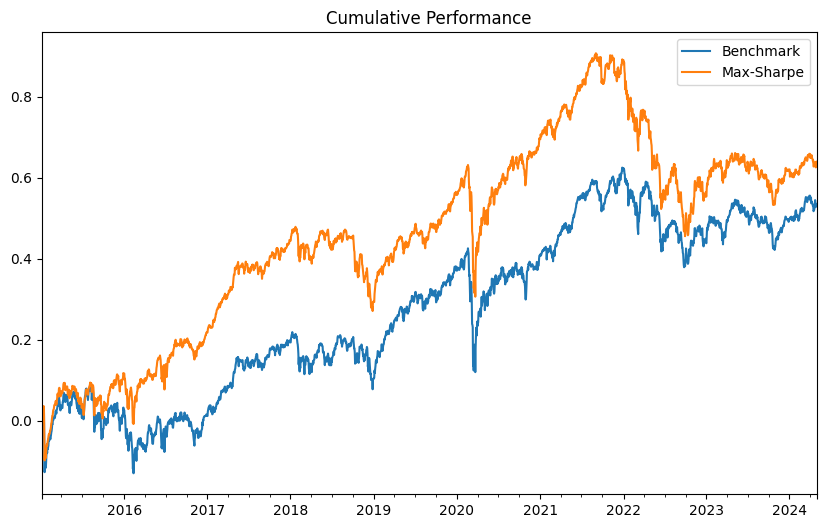

In [16]:
import empyrical as ep

return_series = bs.data.get_return_series()  # Get the underlying asset returns
bm_series = bs.data.bm_series  # Get benchmark returns

fixed_cost = 0.01  # 1%
variable_cost = 0.003  # 0.3%

sim_maxsharpe = bt_ms.strategy.simulate(
    return_series=return_series,
    fc=fixed_cost,
    vc=variable_cost
)

sim = pd.concat({
    'Benchmark': bm_series,
    'MaxSharpe': sim_maxsharpe
}, axis=1).dropna()
sim.columns = ['Benchmark', 'Max-Sharpe']

# Plot the cumulative performance
np.log((1 + sim)).cumsum().plot(title='Cumulative Performance', figsize = (10, 6))


Annualized Turnover ≈ 99.32%


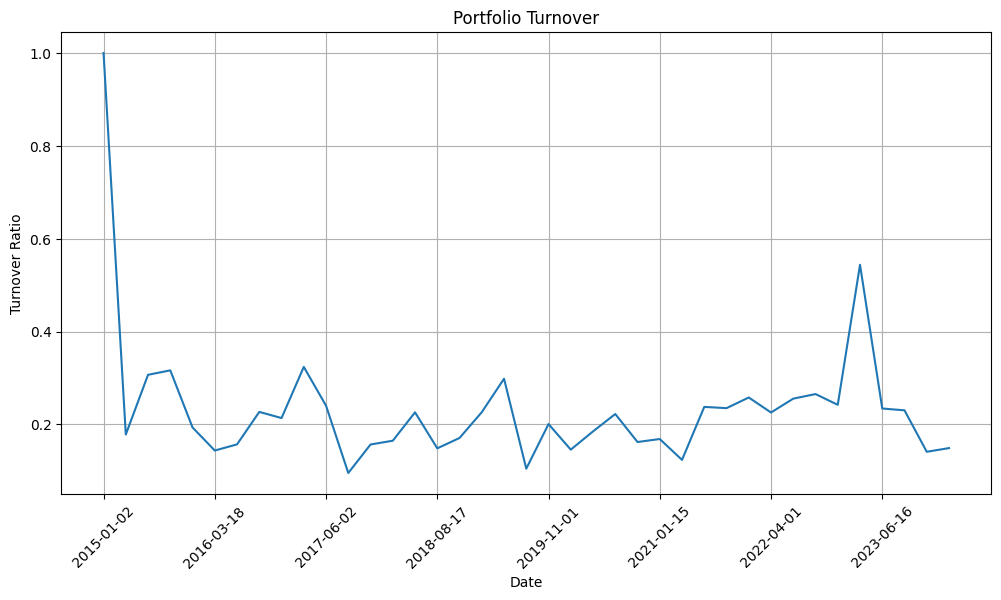

In [18]:
# Turnover Part
turnover_series = bt_ms.strategy.turnover(
    return_series=bs.data.get_return_series(),
    rescale=False  
)

turnover_series.plot(
    title='Portfolio Turnover',
    xlabel='Date',
    ylabel='Turnover Ratio',
    grid=True,
    figsize=(12, 6),
    rot = 45
)

idx = pd.to_datetime(turnover_series.index)
years = (idx[-1] - idx[0]).days / 365.25
reb_freq = len(idx) / years
annual_turnover = turnover_series.mean() * reb_freq
print(f"Annualized Turnover ≈ {annual_turnover:.2%}")

In [19]:
# Compute individual performance metrics for each simulated strategy using empyrical
annual_return = {}
cumulative_returns = {}
annual_volatility = {}
sharpe_ratio = {}
max_drawdown = {}
tracking_error = {}
for column in sim.columns:
    print(f'Performance metrics for {column}')
    annual_return[column] = ep.annual_return(sim[column])
    cumulative_returns[column] = ep.cum_returns(sim[column]).tail(1).values[0]
    annual_volatility[column] = ep.annual_volatility(sim[column])
    sharpe_ratio[column] = ep.sharpe_ratio(sim[column])
    max_drawdown[column] = ep.max_drawdown(sim[column])
    tracking_error[column] = ep.annual_volatility(sim[column] - sim['Benchmark'])


annual_returns = pd.DataFrame(annual_return, index=['Annual Return'])
cumret = pd.DataFrame(cumulative_returns, index=['Cumulative Return'])
annual_volatility = pd.DataFrame(annual_volatility, index=['Annual Volatility'])
sharpe  = pd.DataFrame(sharpe_ratio, index=['Sharpe Ratio'])
mdd = pd.DataFrame(max_drawdown, index=['Max Drawdown'])
tracking_error = pd.DataFrame(tracking_error, index=['Tracking Error'])
pd.concat([annual_returns, cumret, annual_volatility, sharpe, mdd, tracking_error])

Performance metrics for Benchmark
Performance metrics for Max-Sharpe


,Benchmark,Max-Sharpe
Annual Return,0.056593,0.067919
Cumulative Return,0.701100,0.885467
Annual Volatility,0.145690,0.141912
Sharpe Ratio,0.451148,0.534405
Max Drawdown,-0.263289,-0.363318
Tracking Error,0.000000,0.069689
